# Test the HALO Downstreaming Pipelines

## Load the library

In [1]:
from typing import Dict, Iterable, Optional
import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import pandas as pd
from complementary_models import torch_infer_nonsta_dir
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0


In [2]:
path = "/mnt/data0/halo/A594/A549_multiome.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='treatment_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

n_genes :6778
fine tune is False
gate decoder initialization n_input 10, n_output 189603,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


## Load pretrained model

In [4]:
model = model.load("model_A594_causal01", adata_mvi)

INFO     File model_A594_causal01/model.pt already downloaded                                
n_genes :6347
fine tune is False
gate decoder initialization n_input 10, n_output 10313,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [5]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()


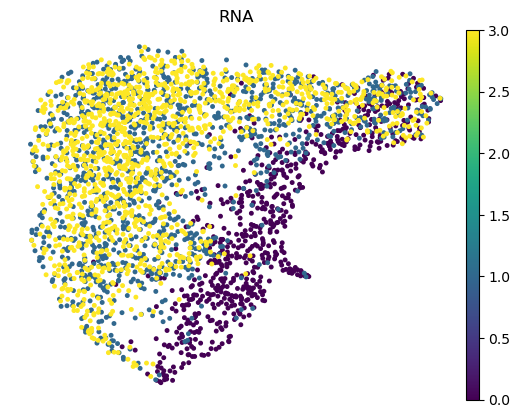

In [6]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['treatment_time'], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

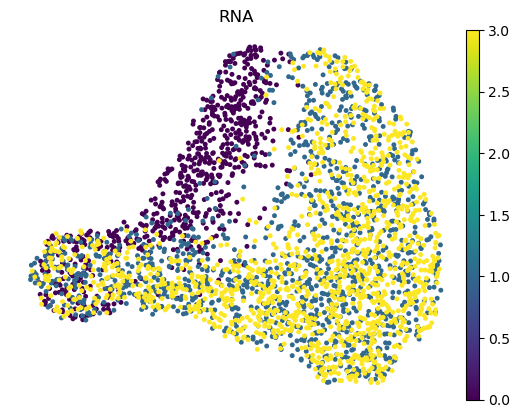

In [7]:
adata_mvi.obsm["latent"] = latent_expr_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['treatment_time'], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

In [8]:
adata_mvi.obs["latent_4"] = latent_expr[:, 4]
adata_mvi.obs["latent_1"] = latent_expr[:,1]
adata_mvi.obs["latent_8"] = latent_expr[:, 8]
adata_mvi.obs["latent_0"] = latent_expr[:, 0]
adata_mvi.obs["latent_2"] = latent_expr[:,2]
adata_mvi.obs["latent_3"] = latent_expr[:, 3]
adata_mvi.obs["latent_5"] = latent_expr[:, 5]
adata_mvi.obs["latent_6"] = latent_expr[:, 6]
adata_mvi.obs["latent_7"] = latent_expr[:, 7]
adata_mvi.obs["latent_9"] = latent_expr[:, 9]


In [9]:
adata_mvi.obs["couple"] = np.mean(np.abs(latent_expr_dep),axis=1)
adata_mvi.obs["decouple"] =  np.mean(np.abs(latent_expr_indep),axis=1)
# adata_mvi.obs["decouple_8"] = latent_expr[:, 8]

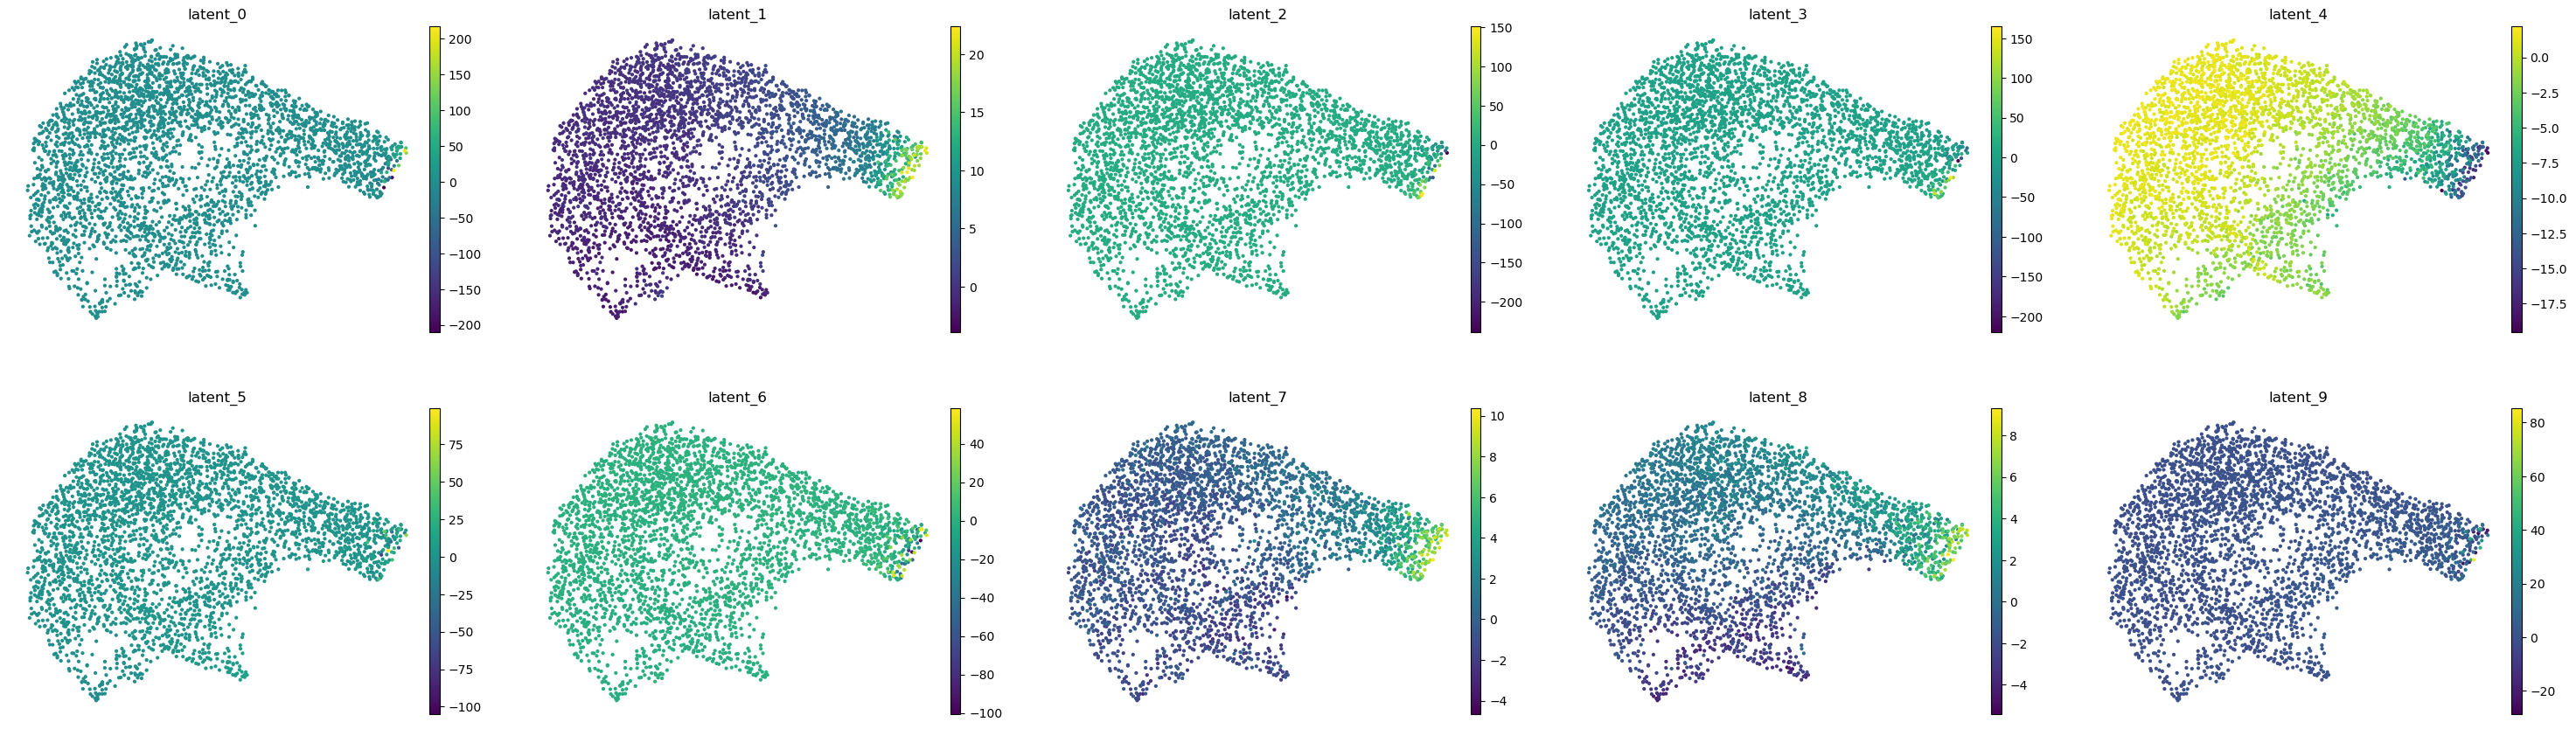

In [29]:
sc.pl.umap(adata_mvi, color  = ['latent_0', 'latent_1', "latent_2","latent_3", "latent_4", "latent_5", "latent_6", "latent_7", "latent_8", "latent_9"], frameon=False, ncols=5)

### get the loading matrix

In [26]:
rnaloading = model.get_rna_loading()
rnaloading = rnaloading.T

[Text(0.5, 14.722222222222216, 'genes')]

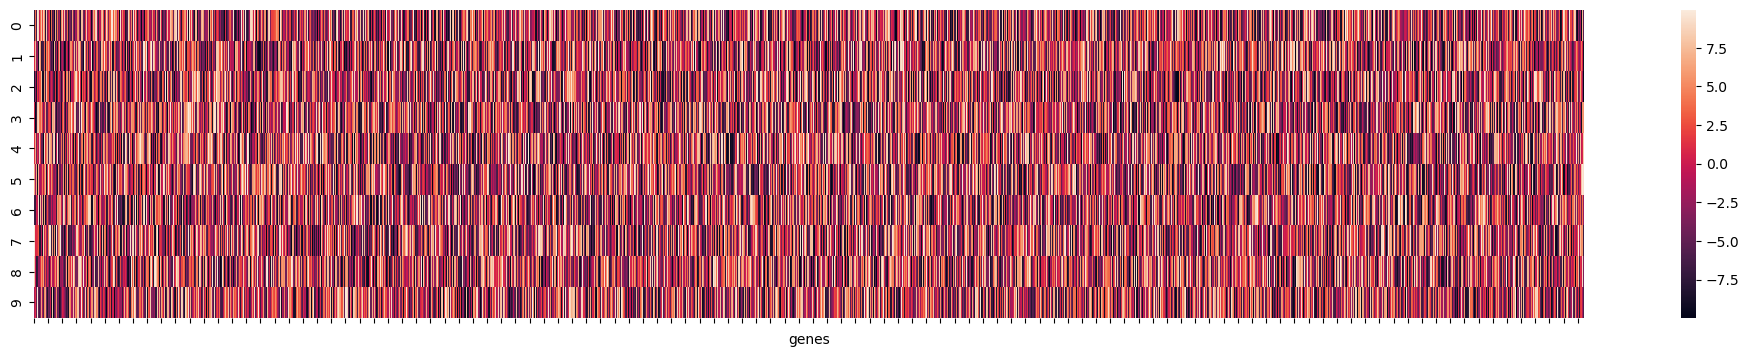

In [277]:
plt.figure(figsize=(25,4))
hm = sns.heatmap(rnaloading)
hm.set(xticklabels=[]) 
hm.set(xlabel="genes")

In [18]:
## get the top genes 
from complementary_models import split_rna,split_atac
rna_data = split_rna(adata_mvi=adata_mvi)
atac_data = split_atac(adata_mvi)

In [19]:
## get RNA data
from complementary_models import split_rna
rna_data_gt = sc.read_h5ad("/mnt/data0/halo/A594/A549_rna.h5ad")
# atac_data = sc.read_h5ad("data/datasets/A549_atac.h5ad")


In [20]:
rna_data_gt.var = rna_data_gt.var.set_index("gene_id")
rna_data_gt.var

,gene_type,gene_short_name,modality,feature_types
gene_id,,,,
ENSG00000223972.4,pseudogene,DDX11L1,Gene Expression,Gene Expression
ENSG00000227232.4,pseudogene,WASH7P,Gene Expression,Gene Expression
ENSG00000243485.2,lincRNA,MIR1302-11,Gene Expression,Gene Expression
ENSG00000237613.2,lincRNA,FAM138A,Gene Expression,Gene Expression
ENSG00000268020.2,pseudogene,OR4G4P,Gene Expression,Gene Expression
...,...,...,...,...
ENSMUSG00000064368.1,protein_coding,mt-Nd6,Gene Expression,Gene Expression
ENSMUSG00000064369.1,Mt_tRNA,mt-Te,Gene Expression,Gene Expression
ENSMUSG00000064370.1,protein_coding,mt-Cytb,Gene Expression,Gene Expression


In [21]:
rna_data.var

,modality,feature_types,n_cells
gene_id,,,
ENSG00000188976.6,Gene Expression,Gene Expression,268
ENSG00000188290.6,Gene Expression,Gene Expression,35
ENSG00000131591.13,Gene Expression,Gene Expression,465
ENSG00000078808.12,Gene Expression,Gene Expression,381
ENSG00000160087.16,Gene Expression,Gene Expression,179
...,...,...,...
ENSMUSG00000105361.1,Gene Expression,Gene Expression,145
ENSMUSG00000048915.12,Gene Expression,Gene Expression,62
ENSMUSG00000092341.2,Gene Expression,Gene Expression,151


In [22]:
gtvar = rna_data_gt.var
rvar = rna_data.var

newvar = pd.merge(rvar, gtvar, how="left", on="gene_id")
newvar = newvar.rename(columns={"modality_x":"modality", "feature_types_x": "feature_types", "gene_short_name":"gene_name"})
newvar = newvar[["gene_type", "gene_name", "n_cells", "modality", "feature_types"]]
newvar.gene_name = newvar.gene_name.astype(str)

In [23]:
rna_data.var = newvar

### get the highly variable genes

In [24]:
sc.pp.filter_genes(rna_data, min_cells=15)
rna_data.raw = rna_data
## normlaize the read depths of each cell, then logarithmize the data:
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)
# Calculate highly variable genes, but with a less stringent dispersion threshold. This set of genes will be our “exogenous” genes:
sc.pp.highly_variable_genes(rna_data, min_disp = 0.2, n_top_genes=None)
rna_data.var['exog'] = rna_data.var.highly_variable.copy()
# Finally, calculate the “endogenous” geneset by intersecting the exogenous set with genes with a higher dispersion threshold:
rna_data.var['endog'] = rna_data.var.exog & (rna_data.var.dispersions_norm > 0.7)
# Restore the raw counts to the counts layer.
rna_data.layers['counts'] = rna_data.raw.to_adata().X.copy()


In [42]:
## add the latent features of model
rna_data.obsm["X_topic_compositions"] = latent_expr_dep

### get the decoupled score and couple scores from the loading matrix

In [27]:
couplescore, decouplescore = model.get_rna_decoupled_score(rnaloading, rnadata=rna_data)
rna_data.var["decouple_score"] = decouplescore
rna_data.var["couple_socre"] = couplescore
rna_data.var

,gene_type,gene_name,n_cells,modality,feature_types,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
gene_id,,,,,,,,,,,,,
ENSG00000188976.6,protein_coding,NOC2L,268,Gene Expression,Gene Expression,False,0.889042,3.534022,-0.113001,False,False,3.968140,1.072871
ENSG00000188290.6,protein_coding,HES4,35,Gene Expression,Gene Expression,True,0.193732,4.115386,1.895071,True,True,1.170143,1.221546
ENSG00000131591.13,protein_coding,C1orf159,465,Gene Expression,Gene Expression,False,1.193560,3.299874,-0.922292,False,False,2.778647,0.878864
ENSG00000078808.12,protein_coding,SDF4,381,Gene Expression,Gene Expression,True,1.241358,3.984616,1.276614,True,True,3.202785,2.587831
ENSG00000160087.16,protein_coding,UBE2J2,179,Gene Expression,Gene Expression,False,0.613243,3.305820,-0.822854,False,False,3.534164,0.350905
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000105361.1,lincRNA,AY036118,145,Gene Expression,Gene Expression,False,0.391519,2.926573,-1.703197,False,False,2.791719,2.464843
ENSMUSG00000048915.12,protein_coding,Efna5,62,Gene Expression,Gene Expression,False,0.211963,3.118958,-0.705720,False,False,1.126025,2.282904
ENSMUSG00000092341.2,lincRNA,Malat1,151,Gene Expression,Gene Expression,False,0.454484,3.066004,-1.319996,False,False,0.163808,4.322021


In [302]:
for e in rna_data.var.sort_values("couple_socre", ascending=False).head(120).gene_name.tolist():
    print(e)

SLC25A13
IRGQ
PRCP
CASP6
SUMO3
CDON
INTS6
RGS10
CALML4
NDUFB1
APPL2
EXOC5
FIBCD1
GABRR1
RP11-318M2.2
ZBTB26
C7orf60
HAS3
PHEX
CDK6
LEPR
AVEN
ANAPC2
WDR77
KCTD13
IGSF9B
MMP24-AS1
IRF3
CNOT1
ZNF800
USMG5
SHROOM3
CALCOCO1
PER1
DUSP16
RNASEL
LMAN2L
C14orf142
CTD-2037K23.2
PEG3
C10orf118
IFT27
AFG3L2
MYO5B
HAUS8
RP11-423O2.5
ANKUB1
RASSF8-AS1
GALK1
TRIM45
ANKRD52
KANSL3
TTLL7
OSGEPL1
RP11-1277A3.2
PPIAP2
CDS2
RP11-770J1.3
NHSL1
B3GNT9
ZNF770
TP53I3
SERPINE1
SP110
CDHR3
ZNF768
IL15RA
MTRF1
PRICKLE1
COL12A1
MRPS33
COTL1
EXOSC5
VIPAS39
ACAA1
SLC16A1
ZNF417
UBXN7
COX11
MLK7-AS1
AL109763.2
FXYD2
GRID1
EMB
OST4
PLCD3
DNAJC12
VEPH1
ARSB
OCIAD2
SULT1A1
TNKS1BP1
SAR1A
Plcxd3
ZNF606
EZH2
SLC25A51
KIF18B
RERG
SYBU
ETNK2
ZMAT4
ASLP1
CLCC1
FRAS1
NOP16
UCK1
CKAP5
TGM2
DCLRE1A
ALDH4A1
NPHP1
KTN1-AS1
EMC3
L3HYPDH
C16orf46
MTMR4
CSNK1D
ORC4
TKT


In [23]:
rna_data.var.sort_values("couple_socre", ascending=False).head(120)

,gene_type,gene_name,n_cells,modality,feature_types,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
gene_id,,,,,,,,,,,,,
ENSG00000004864.9,protein_coding,SLC25A13,768,Gene Expression,Gene Expression,False,1.683635,3.558052,-0.247285,False,False,2.327072,8.441838
ENSG00000167378.4,protein_coding,IRGQ,70,Gene Expression,Gene Expression,True,0.285110,3.777388,1.012857,True,True,2.059948,8.076430
ENSG00000137509.6,protein_coding,PRCP,233,Gene Expression,Gene Expression,True,0.850394,3.726249,0.536571,True,False,2.915731,7.906061
ENSG00000138794.5,protein_coding,CASP6,108,Gene Expression,Gene Expression,False,0.388178,3.159253,-1.063720,False,False,0.325425,7.617265
ENSG00000184900.11,protein_coding,SUMO3,44,Gene Expression,Gene Expression,False,0.215501,3.413889,0.064082,False,False,2.736481,7.521372
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000166455.9,protein_coding,C16orf46,50,Gene Expression,Gene Expression,False,0.165778,2.976916,-1.076466,False,False,0.022570,5.969113
ENSG00000108389.5,protein_coding,MTMR4,125,Gene Expression,Gene Expression,True,0.546091,3.858436,0.845871,True,True,1.530455,5.963612
ENSG00000141551.10,protein_coding,CSNK1D,827,Gene Expression,Gene Expression,True,1.905121,3.739799,0.744283,True,True,4.479718,5.953972


In [308]:
rna_data.var.sort_values("couple_socre", ascending=False).head(120)

,gene_type,n_cells,modality,feature_types,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
gene_name,,,,,,,,,,,,
SLC25A13,protein_coding,768,Gene Expression,Gene Expression,False,1.683635,3.558052,-0.247285,False,False,2.323987,8.432497
IRGQ,protein_coding,70,Gene Expression,Gene Expression,True,0.285110,3.777388,1.012857,True,True,2.057630,8.067747
PRCP,protein_coding,233,Gene Expression,Gene Expression,True,0.850394,3.726249,0.536571,True,False,2.912708,7.897422
CASP6,protein_coding,108,Gene Expression,Gene Expression,False,0.388178,3.159253,-1.063720,False,False,0.325236,7.608836
SUMO3,protein_coding,44,Gene Expression,Gene Expression,False,0.215501,3.413889,0.064082,False,False,2.733310,7.513123
...,...,...,...,...,...,...,...,...,...,...,...,...
C16orf46,protein_coding,50,Gene Expression,Gene Expression,False,0.165778,2.976916,-1.076466,False,False,0.022683,5.962592
MTMR4,protein_coding,125,Gene Expression,Gene Expression,True,0.546091,3.858436,0.845871,True,True,1.528618,5.956735
CSNK1D,protein_coding,827,Gene Expression,Gene Expression,True,1.905121,3.739799,0.744283,True,True,4.474450,5.947460


In [301]:
for e in rna_data.var.sort_values("decouple_score", ascending=False).head(100).gene_name.tolist():
    print(e)

RFC3
SSFA2
INPP5E
CPOX
PTGES
PEX6
CCDC173
IGF1
GALNT4
AKNAD1
MITF
HAUS3
PYROXD2
ZNF445
CTD-3195I5.1
KDM4A-AS1
PRRT3
DDX23
RPL39
FIGF
ISG20L2
LMNB2
TSTA3
AC009961.3
MAST4
ARRDC3
LSAMP
ZBTB2
HMGB1
IMPAD1
ZNF689
EDEM2
CTD-3131K8.2
RP11-529H2.2
FAM86EP
HAGH
A4GALT
RANBP3
PPP1R15B
ZNFX1
FASN
FBXO3
FIZ1
ZNF467
FAM24B
AGPAT9
AC020594.5
RHOG
MAP7D2
MBIP
RDH14
RP11-688I9.4
FSD2
ADAMTS12
YTHDC1
RP11-541P9.3
KLF7-IT1
RP11-434D11.4
ZNF189
NEK3
LARGE
FLNB-AS1
ST3GAL1
STK10
MLKL
MBD4
ZCRB1
SCNN1A
MED4
PPP4R1
PACSIN3
RIN1
TAF1A
RP11-336A10.2
NAMPT
SAMD15
CENPJ
FAM114A1
UNC5C
ASTN2
TLN1
DPYD-IT1
SPSB3
ARAP3
TUBGCP2
SGCB
COA4
LMCD1-AS1
KCTD13
THAP7
ARRB1
RP11-508N12.2
SHPK
DENND4A
APBB1
TMED5
SEMA4D
BCL7B
CENPM
CLTB


In [221]:
## get the top genes
def _argsort_geness(latent_num, loadings):
    return np.argsort(np.abs(loadings[latent_num, :]))

def get_top_genes(top_num, loadingmatrix, latent_index, rnadata, gene_name_col="gene_name"):

    gene_index = _argsort_geness(latent_index,  loadings=loadingmatrix)[-top_num : ]
    # gene_index = _argsort_geness(latent_index,  loadings=loadingmatrix)
    # subframe = rnadata.var.reset_index().loc[gene_index,:]
    gene_name = rnadata.var.reset_index().loc[gene_index, gene_name_col]
    return gene_name.tolist()

In [238]:
topgenes = get_top_genes(100, loadingmatrix=rnaloading, latent_index=1, rnadata =rna_data)

In [239]:
# rna_data.var = rna_data.var.set_index("gene_name")
toptable = rna_data.var.loc[topgenes,:]
toptable[(toptable.highly_variable==True) & (toptable.n_cells>500)]

,gene_type,n_cells,modality,feature_types,highly_variable,means,dispersions,dispersions_norm,exog,endog
gene_name,,,,,,,,,,
ZMAT4,protein_coding,689,Gene Expression,Gene Expression,True,1.738082,3.747051,0.386836,True,False
SLC38A10,protein_coding,728,Gene Expression,Gene Expression,True,1.850022,3.976545,2.214522,True,True
CD63,protein_coding,745,Gene Expression,Gene Expression,True,1.796807,3.695964,0.472058,True,False
FLNA,protein_coding,1214,Gene Expression,Gene Expression,True,2.454150,3.897427,1.550364,True,True


In [38]:
rna_data.obsm["X_umap"] = adata_mvi.obsm["X_umap"]
# rna_data.var = rna_data.var.set_index("gene_short_name")
# rna_data.var.gene_name = rna_data.var.gene_name.astype(str)
# rna_data.var = rna_data.var.set_index("gene_name")
# rna_data.var.index = rna_data.var.index.astype(str)


In [322]:
"NOC2L" in rna_data.var_names

True

In [319]:
type(rna_data.var.index[1])

str

In [50]:
rna_data.var_names = rna_data.var.gene_name.astype(str)

sc.pl.umap(rna_data, color = ["NOC2L", "CDK6", "TP5313"],  frameon=False, cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))

KeyError: 'NOC2L'

<Figure size 2183.4x480 with 0 Axes>

In [111]:
['MAGT1', 'RANBP9', 'BAG1', 'ZNF280D', 'TMEM161A']

['MAGT1', 'RANBP9', 'BAG1', 'ZNF280D', 'TMEM161A']

In [49]:
rna_data

AnnData object with n_obs × n_vars = 3260 × 6347
    obs: 'cell_name', 'experiment', 'treatment_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'latent_4', 'latent_1', 'latent_8', 'latent_0', 'latent_2', 'latent_3', 'latent_5', 'latent_6', 'latent_7', 'latent_9', 'couple', 'decouple'
    var: 'gene_type', 'gene_name', 'n_cells', 'modality', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog', 'decouple_score', 'couple_socre'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap', 'X_topic_compositions'
    layers: 'counts'

In [29]:
## save the data
rna_data.obsm["X_topic_compositions"] = latent_expr + latent_acc
rna_data.obsm["X_umap"] = latent_expr + latent_acc
rna_data.write_h5ad("data/datasets/A594_rna_interim.h5ad")

In [327]:
## split the atac data
from complementary_models import split_atac, reindex_atac

atac_data = split_atac(adata_mvi=adata_mvi)
# atac_data = reindex_atac(atac_data)
atac_data

AnnData object with n_obs × n_vars = 3260 × 10313
    obs: 'cell_name', 'experiment', 'treatment_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'latent_4', 'latent_1', 'latent_8', 'latent_0', 'latent_2', 'latent_3', 'latent_5', 'latent_6', 'latent_7', 'latent_9', 'couple', 'decouple'
    var: 'modality', 'feature_types', 'n_cells'

In [328]:
atac_data_gt = sc.read_h5ad("/mnt/data0/halo/A594/A549_atac.h5ad")
atac_data_gt

AnnData object with n_obs × n_vars = 3260 × 189603
    obs: 'source', 'group', 'experiment'
    var: 'id', 'peak', 'chr', 'start', 'end'

In [329]:
atac_data.var.index = atac_data.var.index.astype(str)
atac_data.var

,modality,feature_types,n_cells
gene_id,,,
1,Peaks,Peaks,389
58,Peaks,Peaks,2881
59,Peaks,Peaks,342
60,Peaks,Peaks,468
61,Peaks,Peaks,3100
...,...,...,...
189393,Peaks,Peaks,49
189399,Peaks,Peaks,57
189518,Peaks,Peaks,120


In [330]:
atac_data_gt.var = atac_data_gt.var.rename(columns={"id": "gene_id"})
atac_data_gt.var = atac_data_gt.var.set_index("gene_id")

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [331]:
atac_data_gt.var.index = atac_data_gt.var.index.astype(str)
atac_data_gt.var

,peak,chr,start,end
gene_id,,,,
1,1-9963-10665,1,9963,10665
2,1-11369-12010,1,11369,12010
3,1-24886-25386,1,24886,25386
4,1-29054-30366,1,29054,30366
5,1-36073-36581,1,36073,36581
...,...,...,...,...
189599,hs37d5-35449616-35449816,hs37d5,35449616,35449816
189600,hs37d5-35450394-35450635,hs37d5,35450394,35450635
189601,hs37d5-35454173-35454373,hs37d5,35454173,35454373


In [332]:
joint_pd = pd.merge(atac_data.var, atac_data_gt.var, on="gene_id", how="inner")
joint_pd

,modality,feature_types,n_cells,peak,chr,start,end
gene_id,,,,,,,
1,Peaks,Peaks,389,1-9963-10665,1,9963,10665
58,Peaks,Peaks,2881,1-563942-565496,1,563942,565496
59,Peaks,Peaks,342,1-565954-566454,1,565954,566454
60,Peaks,Peaks,468,1-567637-568137,1,567637,568137
61,Peaks,Peaks,3100,1-568415-569780,1,568415,569780
...,...,...,...,...,...,...,...
189393,Peaks,Peaks,49,hs37d5-32414215-32415544,hs37d5,32414215,32415544
189399,Peaks,Peaks,57,hs37d5-32574754-32576174,hs37d5,32574754,32576174
189518,Peaks,Peaks,120,hs37d5-34974775-34975894,hs37d5,34974775,34975894


In [334]:
atac_data.var = joint_pd

In [335]:
atac_data.write_h5ad("data/datasets/A594_atac_interim.h5ad")

### Merge the atac data with the anotation


In [38]:
[e for e in rna_data.var.index if "xrcc" in str(e).lower()]

['Xrcc5', 'Xrcc2', 'Xrcc1', 'Xrcc3', 'Xrcc4', 'Xrcc6']

In [39]:
rna_data.var.loc["Xrcc4"]

gene_ids            ENSMUSG00000021615
feature_types          Gene Expression
modality               Gene Expression
n_cells                           1193
highly_variable                   True
means                         0.533738
dispersions                   0.957531
dispersions_norm              1.040948
exog                              True
endog                             True
decouple_score                3.188043
couple_socre                  3.137704
Name: Xrcc4, dtype: object

In [41]:
rna_data.var[rna_data.var.highly_variable==True].sort_values("couple_socre", ascending=False).head(10)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
Snx8,ENSMUSG00000029560,Gene Expression,Gene Expression,158,True,0.066791,0.680346,0.562029,True,False,1.292411,8.018675
Top2a,ENSMUSG00000020914,Gene Expression,Gene Expression,440,True,0.674346,2.725963,4.509905,True,True,0.905042,7.716978
Nemp1,ENSMUSG00000040195,Gene Expression,Gene Expression,478,True,0.178601,0.669797,0.533338,True,False,0.166596,7.690342
Pcdh18,ENSMUSG00000037892,Gene Expression,Gene Expression,260,True,0.099357,0.612424,0.377289,True,False,1.467904,7.629585
Gm15155,ENSMUSG00000055109,Gene Expression,Gene Expression,96,True,0.051634,1.120093,1.758094,True,True,3.766707,7.612002
Tank,ENSMUSG00000064289,Gene Expression,Gene Expression,806,True,0.317087,0.678086,0.328785,True,False,2.529274,7.536418
Ripk1,ENSMUSG00000021408,Gene Expression,Gene Expression,224,True,0.083013,0.593771,0.326556,True,False,0.495087,7.509144
Atf6,ENSMUSG00000026663,Gene Expression,Gene Expression,1234,True,0.461483,0.636022,0.221585,True,False,0.915401,7.501701
Acvr2a,ENSMUSG00000052155,Gene Expression,Gene Expression,2064,True,0.961082,1.074425,0.560879,True,False,0.743466,7.200153
6030443J06Rik,ENSMUSG00000097207,Gene Expression,Gene Expression,318,True,0.132092,0.756852,0.770118,True,True,2.529289,7.094105


In [5]:
import anndata as ad
import tools
import logging

In [6]:
atac_data = ad.read_h5ad("data/datasets/A594_atac_interim.h5ad")
atac_data.var.head()

,modality,feature_types,n_cells,peak,chr,start,end
gene_id,,,,,,,
1,Peaks,Peaks,389,1-9963-10665,1,9963,10665
58,Peaks,Peaks,2881,1-563942-565496,1,563942,565496
59,Peaks,Peaks,342,1-565954-566454,1,565954,566454
60,Peaks,Peaks,468,1-567637-568137,1,567637,568137
61,Peaks,Peaks,3100,1-568415-569780,1,568415,569780


INFO:tools.motif_scan:Getting peak sequences ...
10313it [00:00, 169843.28it/s]
INFO:tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:tools.motif_scan:Building motif background models ...


Exception: Error while scanning for motifs: /bin/sh: 1: moods-dna.py: not found
